# Predicting Ratings from 1+ GB of Yelp Reviews

Let's take a look at the Yelp data. It's about 1.25 Gigabytes, so I really don't want to read that all into my Macbook Air's memory. I'll read in 10,000 rows and just take a quick look.

In [1]:
import pandas as pd
import numpy as np
from __future__ import division
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reviews_data = pd.read_csv('/Users/nickbecker/Python_Projects/yelp_academic_challenge/yelp_academic_dataset_review.csv',
                             nrows = 10000)
reviews_data.head(3)

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,Xqd0DzHaiyRqVH3WRG7hzg,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,5,2007-05-17,review,2
1,H1kH6QZV7Le4zqTRNxoZow,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",0,vcNAWiLM4dR7D2nwwJ7nCA,0,2,2010-03-22,review,2
2,zvJCcrpm2yOZrxKffwGQLA,-TsVN230RCkLYKBeLsuz7A,Dr. Goldberg has been my doctor for years and ...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-02-14,review,1


In [43]:
print reviews_data.iloc[1000, :].text

I've been going here since I was a wee tot.  I have always enjoyed their food even though there's nothing too special about it.  I really like their breakfast menu.  You always seem to get lots of food for very little money, which is nice.  

My only complaint is that it is WAY TOO SMALL and always very busy.  They should really look at expanding the restaurant.


Okay, so that seems like a prety good review. They liked the food and the quantity, but didn't like the size and business of the restaurant. Definitely positive, but probably a 4 star instead of a 5 star since they had some complaints. Let's check.

In [69]:
print reviews_data.iloc[1000, :].stars

5


Well I was wrong. It's a 5 star review. This is a perfect of example of why classifying sentiment (or ratings) from text is hard. Fortunately, for this post, I'll focus on predicting only whether reviews are positive (4 or 5 stars) or negative (1 or 2 stars). This is an easier problem, and is potentially just as useful.

## Training a model with big data?

Normally I'd define 'big data' as data too large to fit into memory (which this is not). But, since the processing time required to analyze this much text is enormous, I'll count this as well. In other situations, we might read the whole dataset into memory and build a tf-idf or bag of words matrix. In fact, I've done that for other text analysis tasks (see []() and []() for examples). But here, since the data is so large, our processing and tokenization time would be gigantic even if we could fit everything into memory.

To get around this, we need to change the optimization process. When the dataset size is small, optimization may be fastest by solving directly for the solution. In OLS linear regression, this would be performing the linear algebra to solve for the optimal weights (w = (X'X)-1X'y). As the dataset becomes larger, gradient descent becomes a more efficient way to find the optimal weights. Gradient descent isn't guaranteed to find the optimal weights (whether it does or not depends on the shape of the loss or likelihood function space), but in practice we are often fine.

However, as the dataset becomes **extremely** large, gradient descent becomes less effective. The size of the data just massively increase the number of steps required for gradient descent to converge. To use our massive amount of data, we need a new method.

## Stochastic Gradient Descent (or Ascent)

Stochastic gradient descent is the solution. Essentially, we're going to do the same gradient descent iteratively on random mini-batches of the data and use these to iteratively update our gradient to (hopefully) reach the optimal solution. Again, we aren't guaranteed to converge to the global optimium (we can get stuck in local optima just like before), but this approach has proven to work extremely well.

As a note, since I'm going to do logistic regression, we're actually maximizing a likelihood function instead of minimizing a loss function. That makes it gradient ascent, instead of descent. 

First, I'll use `pandas.read_csv` to create an iterator object with chunks of size 1000. With this, I can loop through the iterator and each loop will return a chunk of size 1000 from the dataset until I reach the end. I'll skip the first 10,000 rows since we already read that into memory and will use that as a validation set.

In [44]:
reviews_iterator = pd.read_csv('/Users/nickbecker/Python_Projects/yelp_academic_challenge/yelp_academic_dataset_review.csv',
                             chunksize = 1000, skiprows = 10000, names = reviews_data.columns)

Next, I'll define a function to clean the review text (the same function I've used before) and a tokenizer to stem the words in the review. The tokenizer will be passed to the HashingVectorizer to capture words that should be treated as the same but have different endings.

In [45]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize

def clean_review(review):
    """
    Function to clean review text to keep only letters and remove stopwords
    Returns a string of the cleaned bill text
    """
    letters_only = re.sub('[^a-zA-Z]', ' ', review)
    words = letters_only.lower().split()
    stopwords_eng = set(stopwords.words("english"))
    useful_words = [x for x in words if not x in stopwords_eng]
    
    # Combine words into a paragraph again
    useful_words_string = ' '.join(useful_words)
    return(useful_words_string)

stemmer = PorterStemmer()

def stem_words(words_list, stemmer):
    return [stemmer.stem(word) for word in words_list]

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_words(tokens, stemmer)
    return stems

I'll apply our functions to the 10,000 reviews in `reviews_data` so we can use them as a validation set. I'll also get rid of the 3 star reviews, as they're neutral on a 5 star scale.

In [46]:
reviews_data = reviews_data.query('stars != 3')
reviews_data['clean_review'] = reviews_data['text'].apply(clean_review)
reviews_data['star_sentiment'] = reviews_data['stars'].apply(lambda x: 1 if x > 3 else 0)

Okay, time to build the model.

In [49]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(decode_error='ignore', n_features = 2**18,
                               tokenizer = tokenize, non_negative=True)
y_classes = np.array([0, 1])
max_iterations = 299

clf_logit_sgd = SGDClassifier(loss = 'log', n_jobs = 2, learning_rate = 'optimal',
                              random_state = 12, verbose = 0, shuffle = True)

validation_accuracy_list = []

x_validation = vectorizer.transform(reviews_data['clean_review'])
y_validation = reviews_data['star_sentiment']

for i, mini_batch in enumerate(reviews_iterator): 
    mini_reviews_data = mini_batch.copy().query('stars != 3')
    mini_reviews_data['clean_review'] = mini_reviews_data['text'].apply(clean_review)
    mini_reviews_data['star_sentiment'] = mini_reviews_data['stars'].apply(lambda x: 1 if x > 3 else 0)

    x_train = vectorizer.transform(mini_reviews_data['clean_review'])
    y_train = mini_reviews_data['star_sentiment']

    clf_logit_sgd.partial_fit(x_train, y_train, classes = y_classes)

    if i % 1 == 0:
        validation_accuracy = clf_logit_sgd.score(x_validation, y_validation)
        validation_accuracy_list.append((i, validation_accuracy))
        print 'Validation Accuracy at {0}: {1}'.format(i, validation_accuracy)
            
    if i >= max_iterations:
        break

Validation Accuracy at 0: 0.825370281892
Validation Accuracy at 1: 0.869804108935
Validation Accuracy at 2: 0.874104156713
Validation Accuracy at 3: 0.877209746775
Validation Accuracy at 4: 0.876493072145
Validation Accuracy at 5: 0.889154323937
Validation Accuracy at 6: 0.891662685141
Validation Accuracy at 7: 0.885570950788
Validation Accuracy at 8: 0.875059722886
Validation Accuracy at 9: 0.876493072145
Validation Accuracy at 10: 0.887004300048
Validation Accuracy at 11: 0.893693263258
Validation Accuracy at 12: 0.892140468227
Validation Accuracy at 13: 0.893215480172
Validation Accuracy at 14: 0.88640707119
Validation Accuracy at 15: 0.889990444338
Validation Accuracy at 16: 0.886168179646
Validation Accuracy at 17: 0.895365504061
Validation Accuracy at 18: 0.900143334926
Validation Accuracy at 19: 0.895365504061
Validation Accuracy at 20: 0.891184902054
Validation Accuracy at 21: 0.896679407549
Validation Accuracy at 22: 0.875776397516
Validation Accuracy at 23: 0.892498805542
Val

Let's see how the accuracy evolved over time. I'll plot the raw accuracy plot and the average of every 10 iterations.

In [64]:
iterations = [x[0] for x in validation_accuracy_list]
accuracies = [x[1] for x in validation_accuracy_list]

n = 10
accuracies_average = np.array(accuracies).reshape(-1, n).mean(axis = 1)
iterations_sampled = [x[0] for i, x in enumerate(validation_accuracy_list) if i % n == 0]

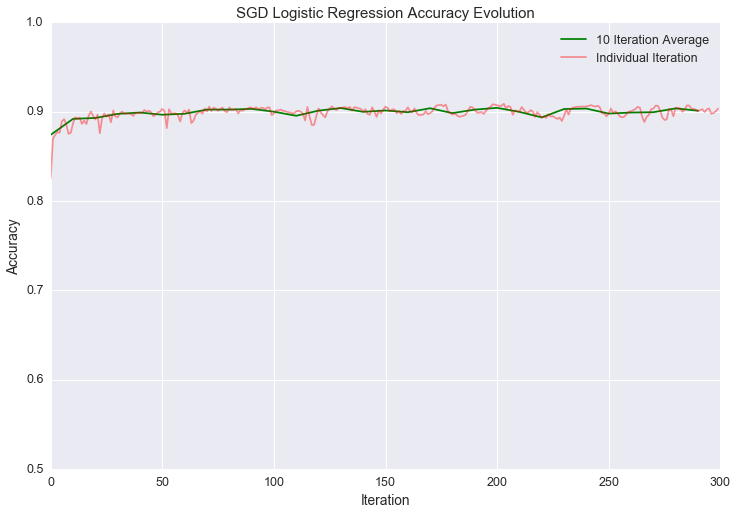

In [78]:
y_min = 0.5
y_max = 1.0

sns.set(font_scale = 1.25)
sns.set_style("darkgrid")
f = plt.figure(figsize = (12, 8))
ax = plt.axes()
plt.title("SGD Logistic Regression Accuracy Evolution")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim(y_min, y_max)
plt.yticks(np.arange(y_min, y_max + .01, .10))
plt.plot(iterations_sampled, accuracies_average,
         'green', label = '10 Iteration Average')
plt.plot([x[0] for x in validation_accuracy_list], [x[1] for x in validation_accuracy_list],
         'red', alpha = 0.4, label = 'Individual Iteration')
plt.legend(loc = 'best')
plt.show()

90% accuracy! That's not bad for minimal pre-processing and a standard logistic regression. If we were smart, we might think that the willingness to give out stars varies across users. It makes sense to account for the fact that some people might systematically give mediocre reviews and 4 stars, while others might systematically write fantastic reviews and only give 4 stars. "Normalizing" the features to account for user history would almost definitely improve the model.

So why might predicting sentiment from reviews be useful? Maybe restaurants would pay for an automated service that tells them when a customer posts about a fantastic or terrible experience at their restaurant. I'd want to make sure to make as few mistakes as possible, so it would make sense to use only the reviews our model classifies above a certain probability of being positive or negative (maybe 95%). This is pretty straightforward with Logistic Regression.

Restaurants could get that kind of feedback by checking Yelp themselves, of course, but a weekly summary with the highlights and lowlights might save enough time and effort to be worth it.

# Concluding Thoughts and Online Learning

I only did 300 iterations of stochastic gradient descent. With a chunksize of 1000, that means the model only used 300,000 reviews. By that time, it was pretty clear the classifier was oscillating around 90% accuracy. We could have trained the model by reading in 300,000 reviews and doing a standard gradient descent. Why might the stochastic way be better (aside from being slightly faster)?

It's better because it lets us do online learning. Online learning is the way we can update our model in near real-time as we acquire more data. Data can come in all the time, and we don't want to train on the entire dataset every time it changes. Stochastic gradient descent let's us build our model in small batches and extremely accurately approximate the gradient descent solution. The flexibility of this approach more than makes up for the slightly more involved coding process when you have big and rapidly increasing data.